In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload 
# always reload modules marked with "%aimport"
%autoreload 1 

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.read_data
from data.read_data import read_data

In [5]:
train, test = read_data(test=True)

In [6]:
print(train.shape)
train.head()

(60000, 6)


,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,77d2dbd504b933ab3aaf7cb0cd81c22f7c3549012f4f88...,1
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1


## Number of target classes

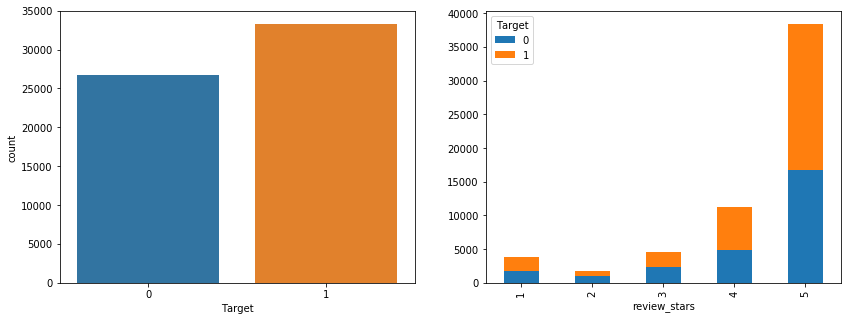

In [7]:
fig, axr = plt.subplots(1,2, figsize=(14,5))
sns.countplot(train['Target'], ax=axr[0])
train.groupby(['Target', 'review_stars']).size().unstack('Target').plot(kind='bar', stacked=True, ax=axr[1])

* Not imbalanced classes
* All classes of review starts have positive and negative samples

## Duplicates

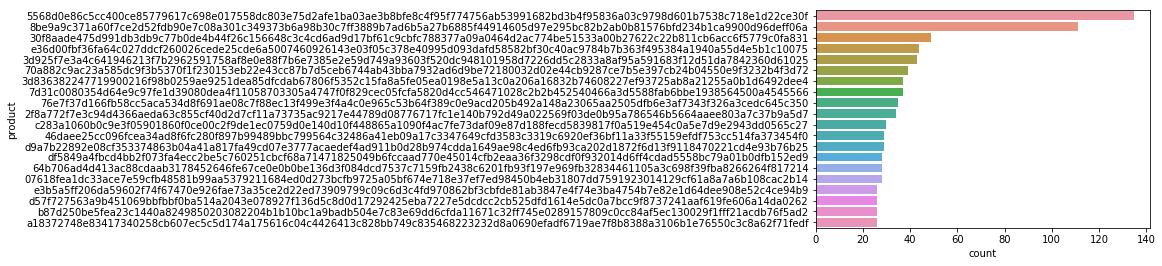

In [8]:
sns.countplot(y=train['product'], order=train['product'].value_counts()[:20].index)

In [9]:
"Appear only one {}, More than one time {}".format((train.groupby('product').size() == 1).sum(),
                                                   (train.duplicated('product', keep=False).sum()))

'Appear only one 40068, More than one time 19932'

Text(0,0.5,'Number of products')

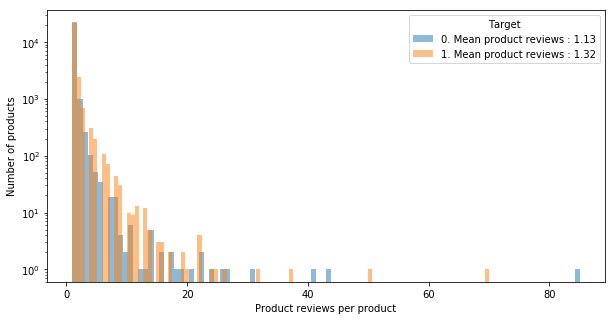

In [32]:
train[train['Target'] == 0].groupby('product').size().plot(kind='hist', logy=True, bins=100, figsize=(10,5), alpha=0.5,
                                                          label='0. Mean product reviews : {:.2f}'.format(train[train['Target'] == 0].groupby('product').size().mean()))
train[train['Target'] == 1].groupby('product').size().plot(kind='hist', logy=True, bins=100, figsize=(10,5), alpha=0.5,
                                                          label='1. Mean product reviews : {:.2f}'.format(train[train['Target'] == 1].groupby('product').size().mean()))
plt.legend(title='Target')
plt.xlabel('Product reviews per product')
plt.ylabel('Number of products')

# Size of posts

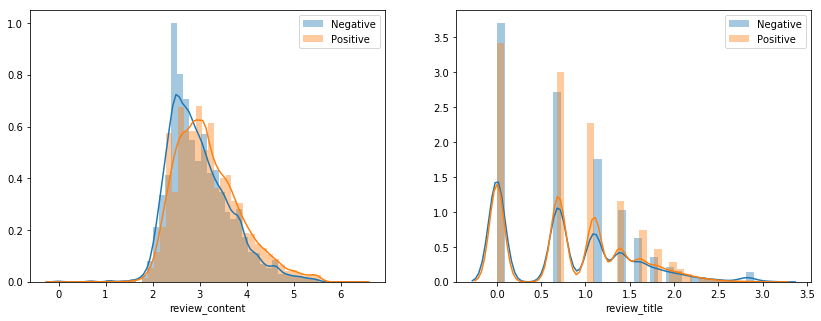

In [161]:
fig, axr = plt.subplots(1,2, figsize=(14,5))
sns.distplot(np.log(train[train['Target'] == 0]['review_content'].apply(lambda x: len(x.split()))), label='Negative', ax=axr[0])
sns.distplot(np.log(train[train['Target'] == 1]['review_content'].apply(lambda x: len(x.split()))), label='Positive', ax=axr[0])
axr[0].legend()

sns.distplot(np.log(train[train['Target'] == 0]['review_title'].dropna().apply(lambda x: len(x.split() if x else np.NaN))), label='Negative', ax=axr[1])
sns.distplot(np.log(train[train['Target'] == 1]['review_title'].dropna().apply(lambda x: len(x.split() if x else np.NaN))), label='Positive', ax=axr[1])
axr[1].legend()

* Large review post tend to be more positive

# Words title

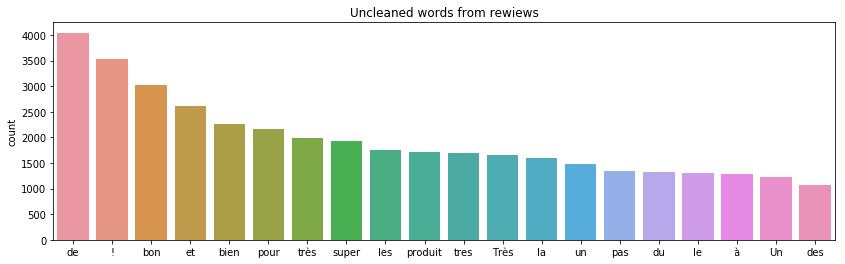

In [20]:
plt.figure(figsize=(14,4))
plt.title('Uncleaned words from rewiews')
sns.countplot(train['review_title'].str.split(expand=True).unstack(),
             order=train['review_title'].str.split(expand=True).unstack().value_counts()[:20].index)

In [35]:
with open('../data/external/fr-stopwords.txt') as fp:
    stopwords = fp.read().splitlines()

In [34]:
positive = train[train['Target'] == 1]['review_title'].dropna().values
negative = train[train['Target'] == 0]['review_title'].dropna().values

(-0.5, 399.5, 199.5, -0.5)

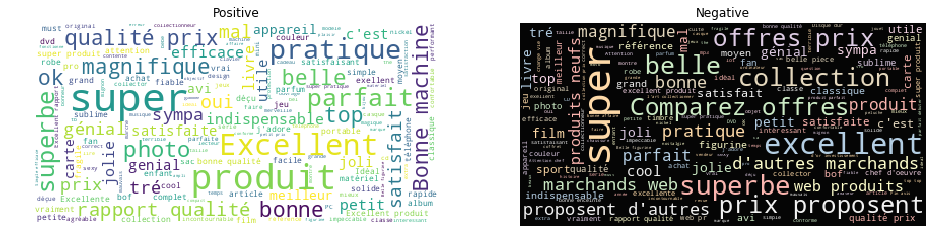

In [50]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
fig, axr = plt.subplots(1,2, figsize=(16,13))
wcP = WordCloud(background_color="white", max_words=10000,
               stopwords=stopwords, max_font_size= 40)
wcN = WordCloud(background_color="black", max_words=10000,
               stopwords=stopwords, max_font_size= 40)
wcP.generate(" ".join(positive))
wcN.generate(" ".join(negative))
#plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
axr[0].set_title('Positive')
axr[1].set_title('Negative')
axr[0].imshow(wcP.recolor( colormap= 'viridis' , random_state=17), alpha=0.98)
axr[1].imshow(wcN.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
axr[0].axis('off'); axr[1].axis('off')

# Words content

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/cris/.virtualenvs/cdiscount/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-4d58ad6b10a4>", line 4, in <module>
    order=train['review_content'].str.split(expand=True).unstack().value_counts()[:20].index)
  File "/home/cris/.virtualenvs/cdiscount/lib/python3.6/site-packages/seaborn/categorical.py", line 3359, in countplot
    errcolor, errwidth, capsize, dodge)
  File "/home/cris/.virtualenvs/cdiscount/lib/python3.6/site-packages/seaborn/categorical.py", line 1596, in __init__
    order, hue_order, units)
  File "/home/cris/.virtualenvs/cdiscount/lib/python3.6/site-packages/seaborn/categorical.py", line 203, in establish_variables
    group_names)
  File "/home/cris/.virtualenvs/cdiscount/lib/python3.6/site-packages/seaborn/categorical.py", line 249, in _group_longform
    g_vals = np.asarray(grouped_vals.get_group(g))
 

KeyboardInterrupt: 

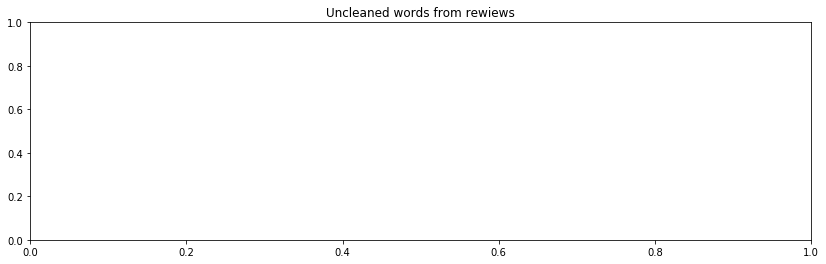

In [33]:
plt.figure(figsize=(14,4))
plt.title('Uncleaned words from rewiews')
sns.countplot(train['review_content'].str.split(expand=True).unstack(),
             order=train['review_content'].str.split(expand=True).unstack().value_counts()[:20].index)

(-0.5, 399.5, 199.5, -0.5)

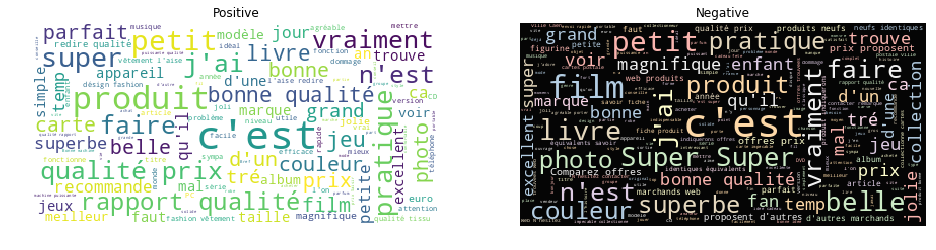

In [36]:
positive = train[train['Target'] == 1]['review_content'].dropna().values
negative = train[train['Target'] == 0]['review_content'].dropna().values

# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
fig, axr = plt.subplots(1,2, figsize=(16,13))
wcP = WordCloud(background_color="white", max_words=10000,
               stopwords=stopwords, max_font_size= 40)
wcN = WordCloud(background_color="black", max_words=10000,
               stopwords=stopwords, max_font_size= 40)
wcP.generate(" ".join(positive))
wcN.generate(" ".join(negative))
#plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
axr[0].set_title('Positive')
axr[1].set_title('Negative')
axr[0].imshow(wcP.recolor( colormap= 'viridis' , random_state=17), alpha=0.98)
axr[1].imshow(wcN.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
axr[0].axis('off'); axr[1].axis('off')

## Lemma

In [37]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/cris/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [42]:
def get_lemmas(text):
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words=stopwords,
                                     decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)
    feature_names = tf_vectorizer.get_feature_names()
    count_vec = np.asarray(tf.sum(axis=0)).ravel()
    zipped = list(zip(feature_names, count_vec))
    x,y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
    return x,y
    

In [52]:
# Storing the entire training text in a list
text_pos = list(train[train['Target'] == 1]['review_content'].dropna().values)
text_neg = list(train[train['Target'] == 0]['review_content'].dropna().values)

In [53]:
x_pos, y_pos = get_lemmas(text_pos)
x_neg, y_neg = get_lemmas(text_neg)

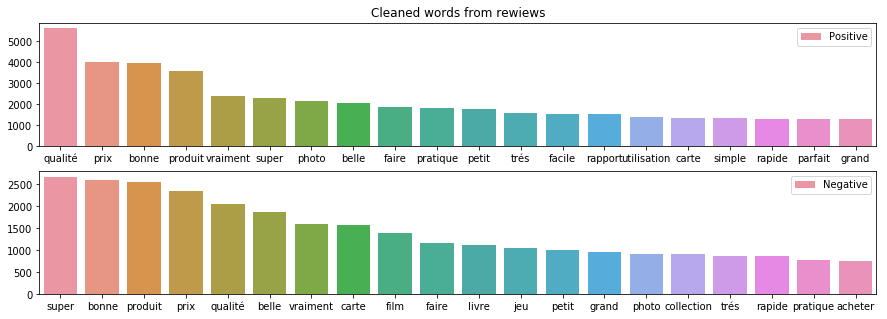

In [60]:
fig, axr = plt.subplots(2,figsize=(15,5))
axr[0].set_title('Cleaned words from rewiews')
sns.barplot(x=x_pos[0:20], y=y_pos[0:20], ax=axr[0], label='Positive')
axr[0].legend()
sns.barplot(x=x_neg[0:20], y=y_neg[0:20], ax=axr[1], label='Negative')
axr[1].legend()

# Tfidf

In [61]:
def get_tfidf(text):
    vectorizer = TfidfVectorizer(min_df=10, max_features=10000, ngram_range=(1, 2))
    vz = vectorizer.fit_transform(list(text))
    tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
    tfidf.columns = ['tfidf']
    return tfidf

In [91]:
vectorizer = TfidfVectorizer(min_df=10, max_features=10000, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(text))

In [135]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [63]:
tfidf_pos = get_tfidf(text_pos)
tfidf_neg = get_tfidf(text_neg)

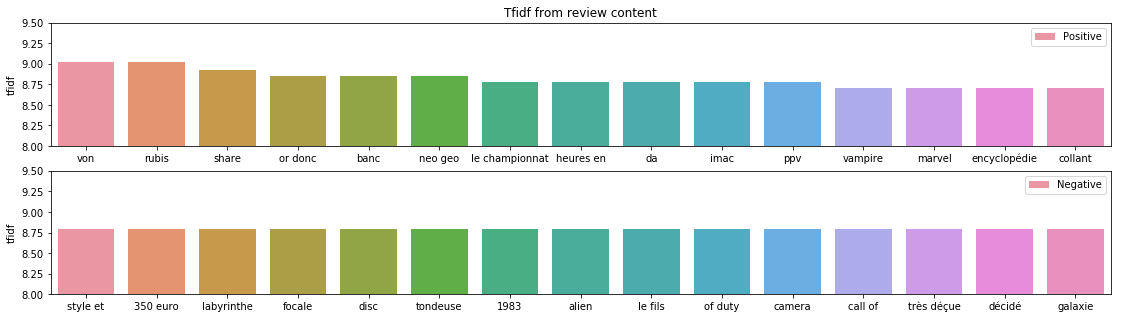

In [103]:
fig, axr = plt.subplots(2,figsize=(19,5))
axr[0].set_title('Tfidf from review content')
df = tfidf_pos.sort_values(by='tfidf', ascending=False).head(15)
sns.barplot(x=df.index, y=df.tfidf, ax=axr[0], label='Positive')
axr[0].set_ylim(8,9.5)
axr[0].legend()
df = tfidf_neg.sort_values(by='tfidf', ascending=False).head(15)
sns.barplot(x=df.index, y=df.tfidf, ax=axr[1], label='Negative')
axr[1].set_ylim(8,9.5)
axr[1].legend()

In [110]:
train['review_title'].dropna().str.split().apply(lambda x: [item for item in x if item not in stopwords])

# Missing values

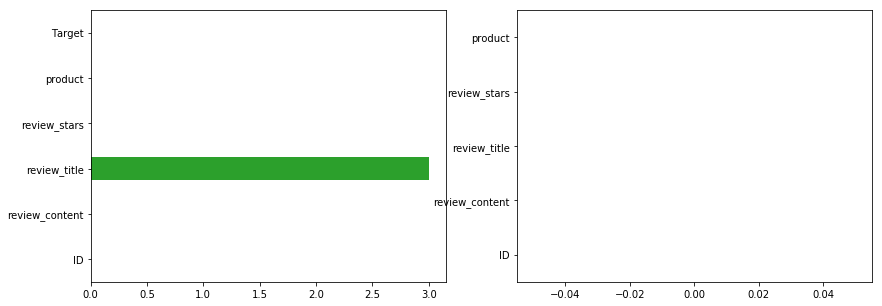

In [73]:
fig, axr = plt.subplots(1,2,figsize=(14,5))
train.apply(lambda col: col.isnull().sum(), axis=0).plot(kind='barh', ax=axr[0])
test.apply(lambda col: col.isnull().sum(), axis=0).plot(kind='barh', ax=axr[1])